# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups      
Sample_108  A0A087WXM8;P50895      15.675
Sample_188  P07737                 16.562
Sample_120  G5E968                 15.609
Sample_017  Q9UM47                 15.391
Sample_024  G3V3X5;G3V511;Q14767   17.140
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups                                        
Sample_138  P31146                                                   12.227
Sample_044  A6NNI4;G8JLH6;P21926                                     16.159
Sample_075  D3YTI2;F2Z2Q9;G5E9R5;P24666;P24666-2;P24666-3;P24666-4   16.682
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.672
            A0A075B6Q5                 13.011
            A0A075B6R2                 13.739
            A0A075B6S5                 13.417
            A0A087WSY4                 12.306
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.543
            Q9UI40;Q9UI40-2            13.227
            Q9UIW2                     12.073
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.727
            Q9UP79                     12.606
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.118,15.050,16.842,19.863,15.743,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.430,19.067,...,15.528,15.576,14.330,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.624,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.965,17.705,17.039,15.532,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.685,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.544,15.345,17.084,18.708,14.249,19.433,12.113,10.730
Sample_207,15.739,16.877,15.469,16.898,15.260,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.672,...,16.012,15.178,12.711,15.050,16.842,19.863,11.810,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.106,19.067,16.188,...,15.528,15.576,13.939,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.751,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.939,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.922,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.998,15.345,17.084,18.708,14.249,19.433,13.204,11.321
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 320.42it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.93it/s]

100%|██████████| 3/3 [00:00<00:00,  4.27it/s]

100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.75it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.71it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.89it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.69it/s]

100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.91it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.46it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.87it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.45it/s]

100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.76it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.49it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.95it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.62it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.54it/s]

100%|██████████| 7/7 [00:01<00:00,  3.46it/s]

100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.75it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.12it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.53it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.36it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.33it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.17it/s]

100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

100%|██████████| 8/8 [00:02<00:00,  3.45it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.75it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.47it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.41it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.22it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.19it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.16it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.12it/s]

100%|██████████| 9/9 [00:02<00:00,  3.21it/s]

100%|██████████| 9/9 [00:02<00:00,  3.30it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.68it/s]

 30%|███       | 3/10 [00:00<00:01,  4.30it/s]

 40%|████      | 4/10 [00:01<00:01,  3.45it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.20it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.07it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.94it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.97it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.06it/s]

100%|██████████| 10/10 [00:03<00:00,  3.22it/s]

100%|██████████| 10/10 [00:03<00:00,  3.31it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.03it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.23it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.11it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.98it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.86it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.83it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.85it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.83it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.01it/s]

100%|██████████| 11/11 [00:03<00:00,  3.19it/s]

100%|██████████| 11/11 [00:03<00:00,  3.08it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.15it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.49it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.94it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.91it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.88it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.80it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.78it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.76it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.83it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.75it/s]

100%|██████████| 12/12 [00:04<00:00,  2.78it/s]

100%|██████████| 12/12 [00:04<00:00,  2.91it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.56it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.66it/s]

 31%|███       | 4/13 [00:01<00:03,  2.74it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.68it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.56it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.58it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.76it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.81it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.81it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.82it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.78it/s]

100%|██████████| 13/13 [00:04<00:00,  2.71it/s]

100%|██████████| 13/13 [00:04<00:00,  2.74it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.10it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.11it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.53it/s]

 36%|███▌      | 5/14 [00:01<00:04,  2.22it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.26it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.27it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.25it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.12it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.26it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.33it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.50it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.46it/s]

100%|██████████| 14/14 [00:05<00:00,  2.48it/s]

100%|██████████| 14/14 [00:05<00:00,  2.43it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.54it/s]

 20%|██        | 3/15 [00:01<00:04,  2.44it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.17it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.26it/s]

 40%|████      | 6/15 [00:02<00:03,  2.29it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.30it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.25it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.30it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.37it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.49it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.59it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.56it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.70it/s]

100%|██████████| 15/15 [00:06<00:00,  2.73it/s]

100%|██████████| 15/15 [00:06<00:00,  2.49it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.072 0.025          0.711 0.396       0.103   
2             0.005 0.003      0.055 0.017          0.687 0.088       0.624   
3             0.004 0.003      0.064 0.024          0.765 0.101       0.720   
4             0.006 0.004      0.069 0.028          0.769 0.096       0.762   
5             0.007 0.006      0.076 0.032          0.765 0.097       0.760   
6             0.006 0.005      0.077 0.034          0.805 0.083       0.782   
7             0.006 0.004      0.078 0.033          0.806 0.084       0.767   
8             0.007 0.007      0.076 0.027          0.811 0.085       0.778   
9             0.007 0.006      0.073 0.026          0.797 0.086       0.791   
10            0.005 0.004      0.061 0.024          0.793 0.081       0.790   
11            0.005 0.003      0.059 0.017          0.793 0.084       0.792   
12            0.005 0.004      0.057 0.017          0.787 0.077       0.803   
13            0.005 0.003      0.058 0.018          0.785 0.078       0.803   
14            0.005 0.003      0.058 0.018          0.791 0.085       0.825   
15            0.005 0.003      0.057 0.018          0.804 0.082       0.816   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.173 0.131                  0.544 0.042        0.857   
2          0.113   0.647 0.080                  0.706 0.059        0.795   
3          0.101   0.736 0.076                  0.776 0.061        0.878   
4          0.108   0.758 0.072                  0.794 0.059        0.879   
5          0.105   0.757 0.073                  0.792 0.061        0.876   
6          0.097   0.789 0.069                  0.820 0.057        0.895   
7          0.098   0.782 0.072                  0.815 0.059        0.895   
8          0.100   0.789 0.072                  0.821 0.059        0.893   
9          0.106   0.789 0.074                  0.820 0.063        0.907   
10         0.106   0.787 0.074                  0.819 0.062        0.905   
11         0.108   0.788 0.077                  0.820 0.064        0.903   
12         0.100   0.791 0.070                  0.821 0.059        0.902   
13         0.100   0.790 0.070                  0.820 0.059        0.901   
14         0.096   0.804 0.069                  0.832 0.059        0.905   
15         0.098   0.806 0.068                  0.834 0.058        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.819 0.083        210.000 0.000  
2          0.064                  0.749 0.084        210.000 0.000  
3          0.052                  0.836 0.075        210.000 0.000  
4          0.051                  0.836 0.074        210.000 0.000  
5          0.052                  0.833 0.074        210.000 0.000  
6          0.048                  0.863 0.067        210.000 0.000  
7          0.049                  0.863 0.069        210.000 0.000  
8          0.050                  0.859 0.070        210.000 0.000  
9          0.046                  0.888 0.055        210.000 0.000  
10         0.047                  0.885 0.056        210.000 0.000  
11         0.049                  0.883 0.058        210.000 0.000  
12         0.049                  0.883 0.057        210.000 0.000  
13         0.049                  0.883 0.056        210.000 0.000  
14         0.048                  0.888 0.054        210.000 0.000  
15         0.046                  0.895 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 446.16it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.90it/s]

100%|██████████| 3/3 [00:00<00:00,  3.83it/s]

100%|██████████| 3/3 [00:00<00:00,  4.00it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.12it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.93it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.27it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.24it/s]

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

100%|██████████| 5/5 [00:02<00:00,  2.30it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.52it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.34it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.84it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.18it/s]

100%|██████████| 6/6 [00:02<00:00,  1.91it/s]

100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.95it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.50it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.84it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.13it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.06it/s]

100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.73it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.53it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.83it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.14it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.83it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.58it/s]

100%|██████████| 8/8 [00:04<00:00,  1.54it/s]

100%|██████████| 8/8 [00:04<00:00,  1.91it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  3.00it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.17it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.02it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.85it/s]

 67%|██████▋   | 6/9 [00:03<00:01,  1.66it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.63it/s]

 89%|████████▉ | 8/9 [00:04<00:00,  1.65it/s]

100%|██████████| 9/9 [00:04<00:00,  1.75it/s]

100%|██████████| 9/9 [00:04<00:00,  1.82it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.83it/s]

 30%|███       | 3/10 [00:00<00:02,  3.34it/s]

 40%|████      | 4/10 [00:01<00:02,  2.79it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.07it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.81it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.76it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.67it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.62it/s]

100%|██████████| 10/10 [00:05<00:00,  1.66it/s]

100%|██████████| 10/10 [00:05<00:00,  1.92it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.91it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.47it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.11it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.66it/s]

 73%|███████▎  | 8/11 [00:04<00:01,  1.73it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.60it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.67it/s]

100%|██████████| 11/11 [00:05<00:00,  1.82it/s]

100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.67it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.13it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.17it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.89it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.73it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.72it/s]

 67%|██████▋   | 8/12 [00:04<00:02,  1.81it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.86it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.03it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.15it/s]

100%|██████████| 12/12 [00:05<00:00,  2.24it/s]

100%|██████████| 12/12 [00:05<00:00,  2.09it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.91it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.27it/s]

 31%|███       | 4/13 [00:01<00:03,  2.89it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.71it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.28it/s]

 54%|█████▍    | 7/13 [00:02<00:03,  1.96it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.69it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.57it/s]

 77%|███████▋  | 10/13 [00:05<00:01,  1.57it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.59it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.68it/s]

100%|██████████| 13/13 [00:06<00:00,  1.81it/s]

100%|██████████| 13/13 [00:06<00:00,  1.95it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.60it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.88it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.23it/s]

 36%|███▌      | 5/14 [00:02<00:04,  1.93it/s]

 43%|████▎     | 6/14 [00:02<00:04,  1.91it/s]

 50%|█████     | 7/14 [00:03<00:04,  1.74it/s]

 57%|█████▋    | 8/14 [00:04<00:03,  1.59it/s]

 64%|██████▍   | 9/14 [00:04<00:03,  1.46it/s]

 71%|███████▏  | 10/14 [00:05<00:02,  1.56it/s]

 79%|███████▊  | 11/14 [00:06<00:01,  1.63it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.82it/s]

 93%|█████████▎| 13/14 [00:07<00:00,  1.83it/s]

100%|██████████| 14/14 [00:07<00:00,  1.86it/s]

100%|██████████| 14/14 [00:07<00:00,  1.86it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.88it/s]

 20%|██        | 3/15 [00:00<00:04,  2.91it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.56it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.44it/s]

 40%|████      | 6/15 [00:02<00:03,  2.32it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.11it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.81it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.62it/s]

 67%|██████▋   | 10/15 [00:05<00:03,  1.60it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.74it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.86it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.96it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.10it/s]

100%|██████████| 15/15 [00:07<00:00,  2.18it/s]

100%|██████████| 15/15 [00:07<00:00,  2.07it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.067 0.024          0.118 0.288       0.013   
2             0.006 0.005      0.066 0.025          0.652 0.120       0.524   
3             0.005 0.003      0.062 0.021          0.815 0.095       0.745   
4             0.005 0.005      0.061 0.023          0.803 0.097       0.744   
5             0.004 0.003      0.051 0.025          0.803 0.090       0.750   
6             0.005 0.003      0.059 0.021          0.800 0.093       0.735   
7             0.006 0.005      0.094 0.030          0.797 0.094       0.736   
8             0.005 0.004      0.066 0.024          0.805 0.105       0.737   
9             0.005 0.004      0.080 0.038          0.811 0.086       0.780   
10            0.005 0.003      0.067 0.027          0.819 0.083       0.791   
11            0.005 0.004      0.072 0.033          0.838 0.091       0.808   
12            0.006 0.005      0.079 0.031          0.834 0.094       0.806   
13            0.006 0.004      0.078 0.035          0.838 0.090       0.818   
14            0.007 0.005      0.073 0.031          0.849 0.085       0.811   
15            0.007 0.006      0.073 0.029          0.844 0.089       0.823   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.034   0.023 0.058                  0.502 0.015        0.872   
2          0.131   0.572 0.109                  0.657 0.078        0.737   
3          0.118   0.774 0.090                  0.809 0.073        0.883   
4          0.112   0.768 0.086                  0.804 0.070        0.881   
5          0.118   0.770 0.085                  0.806 0.069        0.883   
6          0.114   0.761 0.085                  0.799 0.068        0.883   
7          0.114   0.760 0.085                  0.797 0.069        0.880   
8          0.113   0.763 0.083                  0.800 0.068        0.880   
9          0.115   0.789 0.074                  0.821 0.062        0.911   
10         0.103   0.800 0.070                  0.830 0.058        0.918   
11         0.115   0.817 0.080                  0.845 0.067        0.927   
12         0.115   0.814 0.082                  0.842 0.069        0.927   
13         0.114   0.823 0.080                  0.849 0.067        0.928   
14         0.099   0.826 0.074                  0.852 0.062        0.932   
15         0.093   0.829 0.070                  0.854 0.060        0.930   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.838 0.087        210.000 0.000  
2          0.087                  0.683 0.100        210.000 0.000  
3          0.055                  0.859 0.069        210.000 0.000  
4          0.055                  0.859 0.069        210.000 0.000  
5          0.053                  0.860 0.068        210.000 0.000  
6          0.053                  0.861 0.069        210.000 0.000  
7          0.054                  0.859 0.069        210.000 0.000  
8          0.056                  0.859 0.073        210.000 0.000  
9          0.046                  0.896 0.058        210.000 0.000  
10         0.044                  0.900 0.056        210.000 0.000  
11         0.042                  0.914 0.051        210.000 0.000  
12         0.042                  0.913 0.052        210.000 0.000  
13         0.043                  0.914 0.051        210.000 0.000  
14         0.040                  0.919 0.049        210.000 0.000  
15         0.042                  0.917 0.052 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 931.86it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 27.28it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 18.11it/s]

100%|██████████| 3/3 [00:00<00:00, 14.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.85it/s]

100%|██████████| 4/4 [00:00<00:00, 14.39it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 18.02it/s]

 80%|████████  | 4/5 [00:00<00:00, 11.25it/s]

100%|██████████| 5/5 [00:00<00:00, 10.75it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.16it/s]

100%|██████████| 6/6 [00:00<00:00, 13.95it/s]

100%|██████████| 6/6 [00:00<00:00, 14.60it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.05it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.79it/s]

100%|██████████| 7/7 [00:00<00:00, 14.76it/s]

100%|██████████| 7/7 [00:00<00:00, 15.28it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.54it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.92it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 11.56it/s]

100%|██████████| 8/8 [00:00<00:00, 12.30it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 21.15it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.21it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 13.01it/s]

100%|██████████| 9/9 [00:00<00:00, 13.46it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.68it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.51it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.97it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.01it/s]

100%|██████████| 10/10 [00:00<00:00, 12.13it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.78it/s]

 45%|████▌     | 5/11 [00:00<00:00, 14.46it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.77it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 13.52it/s]

100%|██████████| 11/11 [00:00<00:00, 12.85it/s]

100%|██████████| 11/11 [00:00<00:00, 13.50it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 17.81it/s]

 33%|███▎      | 4/12 [00:00<00:00, 11.49it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.30it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.25it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  9.25it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  9.14it/s]

100%|██████████| 12/12 [00:01<00:00,  9.64it/s]

100%|██████████| 12/12 [00:01<00:00,  9.71it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.07it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.45it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.48it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.30it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 11.62it/s]

100%|██████████| 13/13 [00:01<00:00, 11.53it/s]

100%|██████████| 13/13 [00:01<00:00, 12.08it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.98it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.92it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.46it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 13.76it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.88it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 12.34it/s]

100%|██████████| 14/14 [00:01<00:00, 12.98it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 17.08it/s]

 33%|███▎      | 5/15 [00:00<00:00, 15.95it/s]

 47%|████▋     | 7/15 [00:00<00:00, 15.05it/s]

 60%|██████    | 9/15 [00:00<00:00, 15.08it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 13.72it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 13.30it/s]

100%|██████████| 15/15 [00:01<00:00, 12.66it/s]

100%|██████████| 15/15 [00:01<00:00, 13.73it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.059 0.020          0.000 0.000       0.000   
2             0.005 0.004      0.056 0.021          0.689 0.103       0.533   
3             0.006 0.009      0.062 0.024          0.658 0.102       0.581   
4             0.004 0.003      0.052 0.015          0.668 0.093       0.599   
5             0.005 0.004      0.069 0.025          0.668 0.094       0.593   
6             0.004 0.001      0.058 0.023          0.682 0.106       0.602   
7             0.006 0.005      0.072 0.030          0.724 0.095       0.677   
8             0.005 0.004      0.060 0.021          0.717 0.104       0.628   
9             0.005 0.003      0.067 0.025          0.698 0.095       0.655   
10            0.005 0.003      0.066 0.022          0.704 0.093       0.666   
11            0.004 0.002      0.055 0.014          0.697 0.091       0.661   
12            0.005 0.003      0.056 0.017          0.695 0.091       0.658   
13            0.006 0.004      0.069 0.026          0.673 0.088       0.631   
14            0.006 0.005      0.073 0.026          0.671 0.088       0.630   
15            0.005 0.003      0.057 0.016          0.670 0.087       0.627   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.725   
2          0.099   0.595 0.080                  0.676 0.057        0.740   
3          0.102   0.612 0.087                  0.679 0.067        0.758   
4          0.098   0.628 0.081                  0.690 0.063        0.771   
5          0.098   0.625 0.082                  0.689 0.063        0.771   
6          0.113   0.633 0.087                  0.696 0.069        0.780   
7          0.104   0.694 0.077                  0.742 0.064        0.811   
8          0.111   0.662 0.081                  0.720 0.061        0.808   
9          0.103   0.670 0.076                  0.721 0.062        0.808   
10         0.105   0.679 0.078                  0.728 0.063        0.809   
11         0.105   0.672 0.073                  0.723 0.060        0.806   
12         0.100   0.671 0.071                  0.721 0.059        0.802   
13         0.108   0.646 0.077                  0.702 0.062        0.802   
14         0.098   0.644 0.073                  0.700 0.059        0.798   
15         0.104   0.642 0.077                  0.699 0.060        0.795   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.671 0.083        210.000 0.000  
2          0.067                  0.675 0.091        210.000 0.000  
3          0.063                  0.684 0.084        210.000 0.000  
4          0.066                  0.706 0.093        210.000 0.000  
5          0.064                  0.709 0.091        210.000 0.000  
6          0.065                  0.732 0.080        210.000 0.000  
7          0.066                  0.751 0.090        210.000 0.000  
8          0.065                  0.747 0.084        210.000 0.000  
9          0.069                  0.747 0.089        210.000 0.000  
10         0.070                  0.744 0.089        210.000 0.000  
11         0.068                  0.741 0.085        210.000 0.000  
12         0.068                  0.734 0.087        210.000 0.000  
13         0.064                  0.739 0.084        210.000 0.000  
14         0.063                  0.734 0.082        210.000 0.000  
15         0.064                  0.730 0.083 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,15,14
score_time,7,7,14
test_precision,8,14,7
test_recall,14,15,7
test_f1,15,15,7
test_balanced_accuracy,15,15,7
test_roc_auc,15,14,7
test_average_precision,15,14,7
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.22it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.24it/s]

 29%|██▊       | 4/14 [00:01<00:05,  1.97it/s]

 36%|███▌      | 5/14 [00:02<00:04,  1.81it/s]

 43%|████▎     | 6/14 [00:03<00:04,  1.78it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.84it/s]

 57%|█████▋    | 8/14 [00:04<00:03,  1.89it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.98it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.00it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.74it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.60it/s]

 93%|█████████▎| 13/14 [00:07<00:00,  1.47it/s]

100%|██████████| 14/14 [00:08<00:00,  1.39it/s]

100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 13.94it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 11.64it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 11.68it/s]

100%|██████████| 7/7 [00:00<00:00, 10.51it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.63it/s]

 20%|██        | 3/15 [00:00<00:03,  3.38it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.47it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.15it/s]

 40%|████      | 6/15 [00:02<00:04,  2.08it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.09it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.20it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.24it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.36it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.24it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.11it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.92it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.94it/s]

100%|██████████| 15/15 [00:06<00:00,  2.13it/s]

100%|██████████| 15/15 [00:06<00:00,  2.22it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


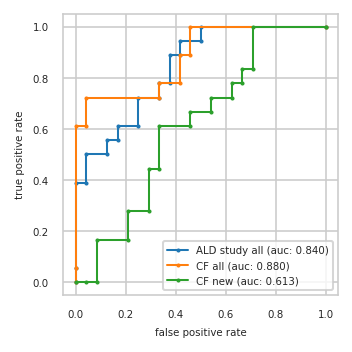

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.389  0.000 0.611  0.083 0.000
3          0.042 0.389  0.042 0.611  0.083 0.167
4          0.042 0.500  0.042 0.722  0.208 0.167
5          0.125 0.500  0.333 0.722  0.208 0.278
6          0.125 0.556  0.333 0.778  0.292 0.278
7          0.167 0.556  0.417 0.778  0.292 0.444
8          0.167 0.611  0.417 0.889  0.333 0.444
9          0.250 0.611  0.458 0.889  0.333 0.611
10         0.250 0.722  0.458 1.000  0.458 0.611
11         0.333 0.722  1.000 1.000  0.458 0.667
12         0.333 0.778    NaN   NaN  0.542 0.667
13         0.375 0.778    NaN   NaN  0.542 0.722
14         0.375 0.889    NaN   NaN  0.625 0.722
15         0.417 0.889    NaN   NaN  0.625 0.778
16         0.417 0.944    NaN   NaN  0.667 0.778
17         0.500 0.944    NaN   NaN  0.667 0.833
18         0.500 1.000    NaN   NaN  0.708 0.833
19         1.000 1.000    NaN   NaN  0.708 1.000
20           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,A0A075B7B8
1,Q8NCL4,H0YMB1;Q96TC7;Q96TC7-2,A0A0C4DGV8;Q13214;Q13214-2
2,O76061,P63104,Q14894
3,A0A0A0MRJ7;P12259,C9JF17;P05090,Q96GD0
4,P61981,Q9Y2T3;Q9Y2T3-3,P31321
5,P14174,A0A0A0MRJ7;P12259,E9PK25;G3V1A4;P23528
6,P04075,P61981,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
7,C9JF17;P05090,P04075,None
8,P00338;P00338-3,Q96GD0,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


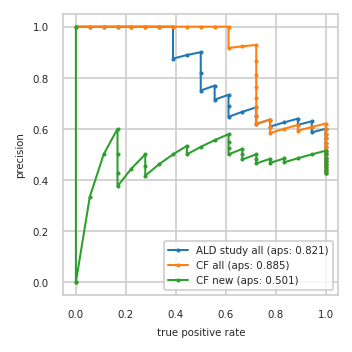

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.484 0.833
12         0.600 1.000     0.600 1.000     0.467 0.778
13         0.586 0.944     0.621 1.000     0.483 0.778
14         0.607 0.944     0.607 0.944     0.464 0.722
15         0.630 0.944     0.593 0.889     0.481 0.722
16         0.615 0.889     0.615 0.889     0.500 0.722
17         0.640 0.889     0.600 0.833     0.480 0.667
18         0.625 0.833     0.583 0.778     0.500 0.667
19         0.609 0.778     0.609 0.778     0.522 0.667
20         0.636 0.778     0.636 0.778     0.500 0.611
21         0.619 0.722     0.619 0.722     0.524 0.611
22         0.650 0.722     0.650 0.722     0.550 0.611
23         0.684 0.722     0.684 0.722     0.579 0.611
24         0.667 0.667     0.722 0.722     0.556 0.556
25         0.647 0.611     0.765 0.722     0.529 0.500
26         0.688 0.611     0.812 0.722     0.500 0.444
27         0.733 0.611     0.867 0.722     0.533 0.444
28         0.714 0.556     0.929 0.722     0.500 0.389
29         0.769 0.556     0.923 0.667     0.462 0.333
30         0.750 0.500     0.917 0.611     0.417 0.278
31         0.818 0.500     1.000 0.611     0.455 0.278
32         0.900 0.500     1.000 0.556     0.500 0.278
33         0.889 0.444     1.000 0.500     0.444 0.222
34         0.875 0.389     1.000 0.444     0.375 0.167
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


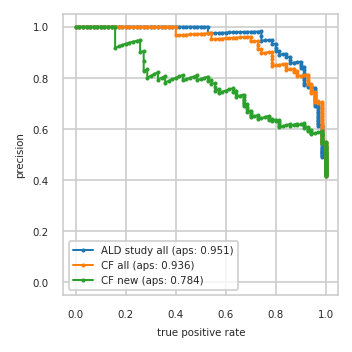

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


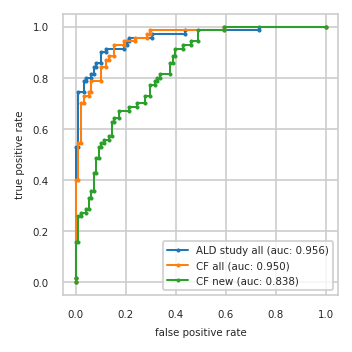

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}